## 数据预处理+建立数据集

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 设定图像预处理的方式
创建transform对象，分别是缩放成224×224大小，数据归一化（直接使用transforms.ToTensor()）

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

### 建立数据集（Dataset）对象
直接使用ImageFolder类，自动对的不同目录进行类别归类。传入transform对象进行图像预处理。

In [3]:
data_images = ImageFolder(root='data/training_set', transform=transform)

In [4]:
# 查看数据集的第1001张图片形状和标签
data_images[1000][0].shape, data_images[1000][1]

(torch.Size([3, 224, 224]), 1)

打乱数据集的顺序，再进行拆分，拆分成训练集和验证集

类别为： 1 ，原图片标号为： 1045


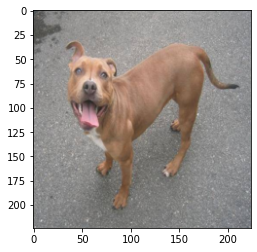

In [5]:
# 直接传入一个乱序的index达到数据集乱序的目的

from torch import randperm
lenth = randperm(len(data_images)).tolist() # 生成乱序的索引
data_images = torch.utils.data.Subset(data_images, lenth)

# 显示一下乱序后的第一张图片
X, y = data_images[0][0], data_images[0][1]
plt.imshow(X.permute([1,2,0]))
print('类别为：', y, '，原图片标号为：', lenth[0])

In [6]:
# 随机拆分Dataset

# 这里训练集和验证集分别大小为 1800 + 200
train_set, val_set = torch.utils.data.random_split(data_images, [1800, 200])
print(len(train_set), len(val_set))

1800 200


### 建立训练集和验证集（DataLoader）

In [7]:
# 创建训练集和验证集的DataLoader，用于训练

train_iter = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_iter = DataLoader(dataset=val_set, batch_size=32)

tensor(0)


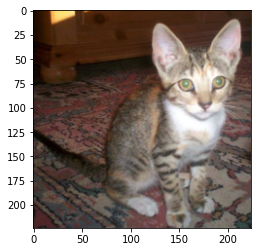

In [8]:
# 预览图片
X, y = next(iter(train_iter))
plt.imshow(X[0].permute([1,2,0]))
print(y[0])

## 训练1（构建简单的CNN模型）

### 构建简单模型
卷积+最大池化+全连接

In [9]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(0.25),
        )
        self.fc = nn.Sequential(
            nn.Linear(112*112*64, 16),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(16, 2),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [10]:
cnn_net = cnn()
print(cnn_net)

cnn(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten()
    (5): Dropout(p=0.25, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=802816, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)


### 定义训练和评估函数

In [11]:
# 定义train函数，使用GPU训练并评价模型
import time

# 测试集上评估准确率
def evaluate_accuracy(data_iter, net, device=None):
    """评估模型预测正确率"""
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就用net的device
        device = list(net.parameters())[0].device

    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval()  # 将模型net调成 评估模式，这会关闭dropout
                # 累加这一个batch数据中判断正确的个数
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train()   # 将模型net调回 训练模式
            else:   # 针对自定义的模型（几乎用不到）
                if('is_training' in net.__code__.co_varnames):  # 如果有is_training这个参数
                    # 将 is_training 设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print('training on ', device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
                % (epoch+1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

### 训练

In [12]:
lr = 0.0001
optimizer = torch.optim.AdamW(cnn_net.parameters(), lr=lr, weight_decay=0.001)
loss = torch.nn.CrossEntropyLoss()
num_epochs = 10

train(train_iter, val_iter, cnn_net, loss, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.8948, train acc 0.500, test acc 0.505, time 17.4 sec
epoch 2, loss 0.3467, train acc 0.499, test acc 0.505, time 15.8 sec
epoch 3, loss 0.2311, train acc 0.499, test acc 0.505, time 15.6 sec
epoch 4, loss 0.1736, train acc 0.498, test acc 0.505, time 15.5 sec
epoch 5, loss 0.1387, train acc 0.499, test acc 0.505, time 15.8 sec
epoch 6, loss 0.1156, train acc 0.499, test acc 0.505, time 15.7 sec
epoch 7, loss 0.0990, train acc 0.499, test acc 0.505, time 15.9 sec
epoch 8, loss 0.0867, train acc 0.499, test acc 0.505, time 15.9 sec
epoch 9, loss 0.0770, train acc 0.499, test acc 0.505, time 16.1 sec
epoch 10, loss 0.0693, train acc 0.499, test acc 0.505, time 15.9 sec


In [13]:
# 释放GPU资源
torch.cuda.empty_cache()

## 训练2（从头训练）

In [14]:
from torchvision import models
model_0 = models.mobilenet_v2()
# 使用mobilenet_v2模型

# 查看模型
print(model_0)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [15]:
# 查看输出模块
print(model_0.classifier)

# 将最后的全连接层修改我们需要的输出类别数 2
model_0.classifier[-1] = nn.Linear(in_features=1280, out_features=2, bias=True)

# 查看修改后的输出模块
print(model_0.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [16]:
# 再次训练
lr = 0.0001
optimizer = torch.optim.AdamW(model_0.parameters(), lr=lr, weight_decay=0.001)
loss = torch.nn.CrossEntropyLoss()
num_epochs = 10

train(train_iter, val_iter, model_0, loss, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.6832, train acc 0.546, test acc 0.495, time 28.7 sec
epoch 2, loss 0.3324, train acc 0.598, test acc 0.620, time 28.4 sec
epoch 3, loss 0.2129, train acc 0.632, test acc 0.595, time 28.6 sec
epoch 4, loss 0.1530, train acc 0.651, test acc 0.580, time 28.4 sec
epoch 5, loss 0.1136, train acc 0.714, test acc 0.585, time 28.5 sec
epoch 6, loss 0.0877, train acc 0.742, test acc 0.640, time 28.7 sec
epoch 7, loss 0.0729, train acc 0.746, test acc 0.595, time 28.4 sec
epoch 8, loss 0.0538, train acc 0.799, test acc 0.620, time 28.5 sec
epoch 9, loss 0.0490, train acc 0.787, test acc 0.555, time 28.7 sec
epoch 10, loss 0.0377, train acc 0.827, test acc 0.545, time 28.7 sec


## 训练3（迁移学习）

In [17]:
# 释放GPU资源
torch.cuda.empty_cache()

In [18]:
model_1 = models.mobilenet_v2(pretrained=True)
# 使用mobilenet_v2的预训练模型

# 查看模型
print(model_1)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [19]:
# 查看输出模块
print(model_1.classifier)

# 将最后的全连接层修改我们需要的输出类别数 2
model_1.classifier[-1] = nn.Linear(in_features=1280, out_features=2, bias=True)

# 查看修改后的输出模块
print(model_1.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [20]:
# 再次训练
lr = 0.0001
optimizer = torch.optim.AdamW(model_1.parameters(), lr=lr, weight_decay=0.001)
loss = torch.nn.CrossEntropyLoss()
num_epochs = 7  # 经测试，7轮过后已经收敛

train(train_iter, val_iter, model_1, loss, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.1469, train acc 0.945, test acc 0.970, time 28.8 sec
epoch 2, loss 0.0120, train acc 0.993, test acc 0.985, time 28.5 sec
epoch 3, loss 0.0070, train acc 0.992, test acc 0.975, time 28.7 sec
epoch 4, loss 0.0034, train acc 0.997, test acc 0.975, time 28.6 sec
epoch 5, loss 0.0027, train acc 0.996, test acc 0.975, time 28.5 sec
epoch 6, loss 0.0011, train acc 0.998, test acc 0.980, time 28.6 sec
epoch 7, loss 0.0014, train acc 0.996, test acc 0.980, time 28.7 sec


## 保存模型
以上对比，可见使用预训练模型+微调的方法得到的模型性能是最优的。<br>
我们保存训练好的模型。

In [21]:
path = 'net.pt'
torch.save(model_1.state_dict(), path)

In [22]:
# 释放GPU资源
torch.cuda.empty_cache()

前向传播可视化

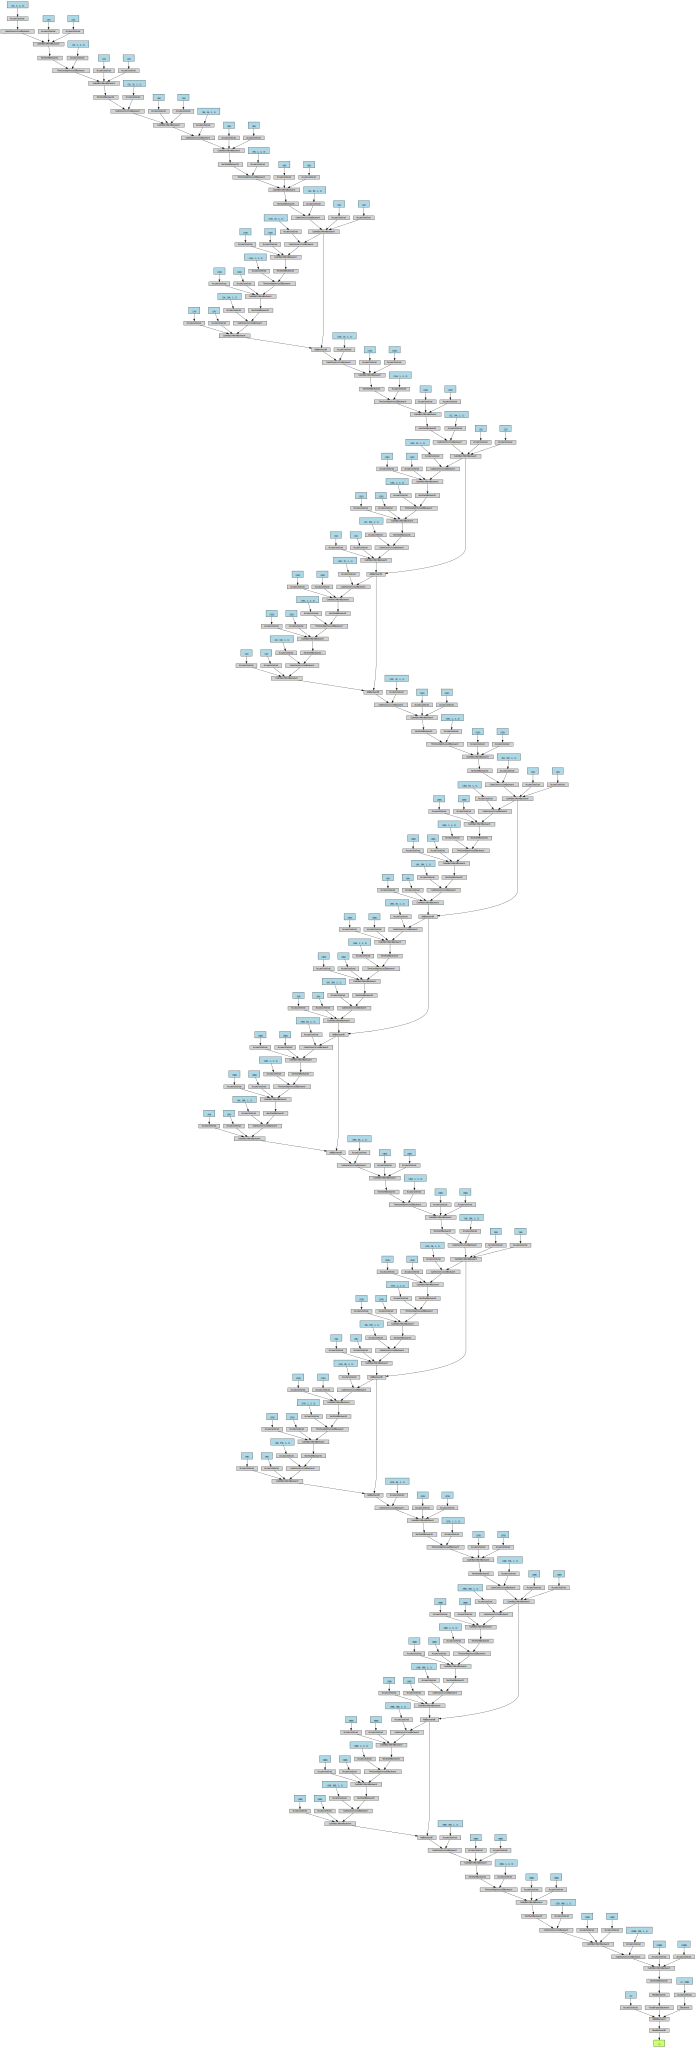

In [25]:
from torchviz import make_dot

y_hat = model_1(X.cuda())
make_dot(y_hat.mean())

## 测试集评估模型效果

### 建立测试集

In [26]:
test_data_images = ImageFolder(root='data/test_set', transform=transform)
test_iter = DataLoader(dataset=test_data_images, batch_size=32)

### 评估

In [27]:
torch.cuda.empty_cache()

# 准确率
acc1 = evaluate_accuracy(test_iter, cnn_net)
acc2 = evaluate_accuracy(test_iter, model_0)
acc3 = evaluate_accuracy(test_iter, model_1)
print('简易CNN模型 测试集上准确率：',acc1)
print('从头训练模型 测试集上准确率：',acc2)
print('微调模型(迁移学习) 测试集上准确率：',acc3)

简易CNN模型 测试集上准确率： 0.5
从头训练模型 测试集上准确率： 0.608
微调模型(迁移学习) 测试集上准确率： 0.982
